## Applying the bias scan tool on a loan approval classifier
In this notebook, the bias scan tool is applied on a XGBoost loan approval classifier. The bias scan tool is based on an implementation of the k-means Hierarchical Bias Aware Clustering (HBAC) method\*. The python script `./helper_functions.py` contains functions that execute the bias scan. A conceptual description how the bias scan works, including the rationale why k-means is chosen as a clustering algorithm and paramater choices, can be found in the [bias scan report](https://github.com/NGO-Algorithm-Audit/AI_Audit_Challenge/blob/master/Bias_scan_tool_report.docx).

The classifier is used to make predictions on the German Credit\*\* data set. Details on pre-processing steps performed on this dataset and the trained XGBoost classifier are provided in the `../case_studies/Loan_approval_classifier/GermanCredit_classifier.ipynb` notebook.

This notebook is structured as follows:
1. Load data and pre-processing
2. Bias scan using k-means clustering
3. Clustering results
4. Statistical testing of inter-cluster difference 

\* Misztal-Radecka, Indurkya, *Information Processing and Management*. Bias-Aware Hierarchical Clustering for detecting the discriminated groups of users in recommendation systems (2021).

\*\* the original dataset, in the form provided by Prof. Hofmann, contains categorical/symbolic attributes which is contained in the file "german.data" [[link to dataset]](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29)

### Load libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

# helper functions
from helper_functions import *

# sklearn
from sklearn.preprocessing import StandardScaler

# welch's t-test
import scipy.stats as stats

### 1. Load data and pre-processing
#### Load data

In [2]:
path = '../case_studies/Loan_approval_classifier/pred_XGBoost.csv'

# read data
entire_dataset = pd.read_csv(path)
entire_dataset.head()

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,predicted_class,true_class,errors
0,21.0,2993.0,3.0,2.0,28.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0.0,0.0
1,30.0,3656.0,4.0,4.0,49.0,2.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0.0,0.0
2,12.0,1255.0,4.0,4.0,61.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0.0,0.0
3,8.0,1414.0,4.0,2.0,33.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0.0,0.0
4,12.0,691.0,4.0,3.0,35.0,2.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0,1.0,1.0


#### Data cleaning

In [3]:
features = entire_dataset.drop(['predicted_class', 'true_class', 'errors'], axis=1)
features.head()

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,housing=A152,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202
0,21.0,2993.0,3.0,2.0,28.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,30.0,3656.0,4.0,4.0,49.0,2.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,12.0,1255.0,4.0,4.0,61.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,8.0,1414.0,4.0,2.0,33.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,12.0,691.0,4.0,3.0,35.0,2.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


#### Scaling data

In [4]:
full_data = init_GermanCredit_dataset(entire_dataset,features)
full_data.head()

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,predicted_class,true_class,errors,clusters,new_clusters
0,0.060492,0.002162,-0.049437,-0.764268,-0.665129,0.943341,-0.447214,-0.623610,-0.592749,-0.281312,...,-0.45257,0.839372,-0.839372,0.195096,-0.195096,0,0.0,0.0,0,-1
1,0.823703,0.254090,0.877513,1.084768,1.180823,0.943341,-0.447214,-0.623610,-0.592749,3.554766,...,-0.45257,0.839372,-0.839372,0.195096,-0.195096,0,0.0,0.0,0,-1
2,-0.702720,-0.658246,0.877513,1.084768,2.235653,0.943341,-0.447214,-0.623610,-0.592749,-0.281312,...,-0.45257,0.839372,-0.839372,0.195096,-0.195096,0,0.0,0.0,0,-1
3,-1.041925,-0.597829,0.877513,-0.764268,-0.225616,-0.711644,-0.447214,-0.623610,1.687055,-0.281312,...,-0.45257,0.839372,-0.839372,-5.125693,5.125693,0,0.0,0.0,0,-1
4,-0.702720,-0.872556,0.877513,0.160250,-0.049811,0.943341,-0.447214,1.603567,-0.592749,-0.281312,...,-0.45257,0.839372,-0.839372,0.195096,-0.195096,0,1.0,1.0,0,-1


### 2. Bias scan using k-means clustering
Clustering algorithms parameters:

In [5]:
clustering_paramaters = {
    "n_clusters": 2,
    "init": "k-means++",
    "n_init": 20,
    "max_iter": 300,
    "random_state": 10,
}

Specify:
- Minimal splittable cluster size
- Minimal acceptable cluster size

In [6]:
# minimal splittable cluster size
split_cluster_size = round(0.05 * len(full_data))
print("minimal splittable cluster size: ", split_cluster_size)

# minimal acceptable cluster size
acc_cluster_size = round(0.03 * len(full_data))
print("minimal splitacceptabletable cluster size: ", acc_cluster_size)

minimal splittable cluster size:  15
minimal splitacceptabletable cluster size:  9


Performing bias scan using helper functions.

In [7]:
iterations_max = 20
x = 0 # initial cluster number
initial_bias = 0
variance_list = []
average_accuracy = accuracy(full_data)
minimal_splittable_cluster_size = round(0.05 * len(full_data))
minimal_acceptable_cluster_size = round(0.03 * len(full_data))
print("average_accuracy is: ", average_accuracy) 

for i in range(1, iterations_max):
    if i != 1:
        variance_list.append(calculate_variance(full_data)) 
    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply Kmeans 
    kmeans_algo = KMeans(**clustering_paramaters).fit(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1))
    
    candidate_cluster['new_clusters'] = pd.DataFrame(kmeans_algo.predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)),index=candidate_cluster.index) 
    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])

    max_abs_bias = get_max_negative_bias(full_data) # was get_max_abs_bias, but now it only finds the discriminated clusters
    min_new_size = get_min_cluster_size(full_data)
    
    if (max_abs_bias <= initial_bias) & (min_new_size > minimal_acceptable_cluster_size): #abs: >
        # add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        
        x = get_next_cluster(full_data)
        initial_bias = max_abs_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('done')

average_accuracy is:  0.75
done


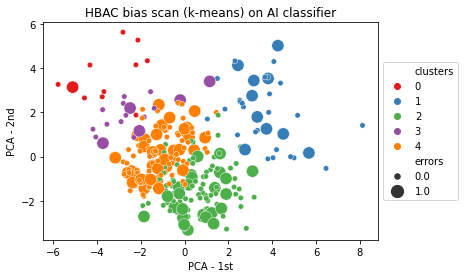

In [8]:
pca_plot(full_data)

### 3. Analysing clustering results
Identifying cluster with most negative bias.

In [9]:
c = get_max_bias_cluster(full_data)
max_bias = round(bias_acc(full_data, c, "clusters"), 2)
highest_biased_cluster = full_data[full_data['clusters']==c]
print(f"cluster {c} has the highest negative bias: " + str(max_bias))
print("#elements in highest biased cluster:", len(highest_biased_cluster))

4 has bias -0.04835144593847851
0 has bias 0.1651462724127084
2 has bias 0.04614074109128763
1 has bias -0.02312198129688625
3 has bias -0.04676782373726873
cluster 4 has the highest negative bias: -0.05
#elements in highest biased cluster: 122


Accuracy of classifier on full dataset and on cluster with highest discrimination bias.

In [10]:
accuracy_full_data = accuracy(full_data)
most_biased_cluster_kmeans_aware = bias_acc(full_data, c, 'clusters')
full_data[full_data['clusters']==c]

print('General accuracy of classifier on this dataset:', accuracy_full_data)

General accuracy of classifier on this dataset: 0.75


Select and print discriminated cluser.

In [11]:
discriminated_cluster = full_data[full_data['clusters']==c]
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
discriminated_cluster

Number of instances in discriminated cluster: 122
Number of errors in discriminated clusters:  34


,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,predicted_class,true_class,errors,clusters,new_clusters
0,0.060492,0.002162,-0.049437,-0.764268,-0.665129,0.943341,-0.447214,-0.623610,-0.592749,-0.281312,...,-0.45257,0.839372,-0.839372,0.195096,-0.195096,0,0.0,0.0,4,-1
1,0.823703,0.254090,0.877513,1.084768,1.180823,0.943341,-0.447214,-0.623610,-0.592749,3.554766,...,-0.45257,0.839372,-0.839372,0.195096,-0.195096,0,0.0,0.0,4,-1
2,-0.702720,-0.658246,0.877513,1.084768,2.235653,0.943341,-0.447214,-0.623610,-0.592749,-0.281312,...,-0.45257,0.839372,-0.839372,0.195096,-0.195096,0,0.0,0.0,4,-1
4,-0.702720,-0.872556,0.877513,0.160250,-0.049811,0.943341,-0.447214,1.603567,-0.592749,-0.281312,...,-0.45257,0.839372,-0.839372,0.195096,-0.195096,0,1.0,1.0,4,-1
7,1.332510,0.464600,0.877513,-0.764268,-0.840934,-0.711644,-0.447214,-0.623610,-0.592749,3.554766,...,-0.45257,0.839372,-0.839372,0.195096,-0.195096,0,1.0,1.0,4,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,2.095722,0.668270,0.877513,-0.764268,-0.928836,0.943341,-0.447214,-0.623610,1.687055,-0.281312,...,-0.45257,0.839372,-0.839372,0.195096,-0.195096,1,1.0,0.0,4,-1
295,0.314895,0.240791,-0.976388,1.084768,-0.401421,0.943341,-0.447214,-0.623610,-0.592749,-0.281312,...,-0.45257,0.839372,-0.839372,0.195096,-0.195096,0,1.0,1.0,4,-1
296,-0.024310,0.488159,-1.903339,1.084768,-1.016739,0.943341,-0.447214,1.603567,-0.592749,-0.281312,...,-0.45257,0.839372,-0.839372,0.195096,-0.195096,0,0.0,0.0,4,-1
298,0.314895,-0.610368,0.877513,-0.764268,-0.049811,-0.711644,-0.447214,1.603567,-0.592749,-0.281312,...,-0.45257,0.839372,-0.839372,0.195096,-0.195096,1,1.0,0.0,4,-1


### 4. Statistical testing of inter-cluster difference 
Compute difference between cluster with highest discrimination bias and rest of dataset.

In [12]:
not_discriminated = full_data[full_data['clusters']!=c]
difference = (discriminated_cluster.mean()) - (not_discriminated.mean()) 
diff_dict = difference.to_dict()
difference

month                             -0.428739
credit_amount                     -0.564056
investment_as_income_percentage    0.147178
residence_since                   -0.228022
age                               -0.273390
                                     ...   
predicted_class                    0.059127
true_class                         0.062903
errors                             0.048351
clusters                           2.235955
new_clusters                       0.000000
Length: 62, dtype: float64

Unscaling the data. Print summary of cluster with highest discrimination bias and the rest of data.

In [13]:
# unscaling the discriminated cluster
unscaled_discriminated = full_data.loc[discriminated_cluster.index, :]

# unscaled other data
unscaled_remaining = full_data.drop(discriminated_cluster.index)

display(unscaled_remaining.describe())
display(unscaled_discriminated.describe())

print(discriminated_cluster.index)

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,predicted_class,true_class,errors,clusters,new_clusters
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,...,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.0
mean,0.174354,0.229383,-0.059853,0.092729,0.111179,0.069361,0.095473,-0.048047,0.073261,-0.044251,...,0.265320,-0.541074,0.541074,-0.133717,0.133717,0.235955,0.297753,0.230337,1.764045,-1.0
std,1.072246,1.144491,1.009617,0.987777,0.981934,1.043444,1.080849,0.977741,1.039651,0.926287,...,1.184765,0.950140,0.950140,1.284795,1.284795,0.425792,0.458560,0.422236,0.705466,0.0
min,-1.211527,-0.988830,-1.903339,-1.688786,-1.368349,-0.711644,-0.447214,-0.623610,-0.592749,-0.281312,...,-0.452570,-1.191367,-0.839372,-5.125693,-0.195096,0.000000,0.000000,0.000000,0.000000,-1.0
25%,-0.702720,-0.598399,-0.976388,-0.764268,-0.577226,-0.711644,-0.447214,-0.623610,-0.592749,-0.281312,...,-0.452570,-1.191367,-0.839372,0.195096,-0.195096,0.000000,0.000000,0.000000,1.000000,-1.0
50%,0.060492,-0.158760,-0.049437,0.160250,-0.049811,-0.711644,-0.447214,-0.623610,-0.592749,-0.281312,...,-0.452570,-1.191367,1.191367,0.195096,-0.195096,0.000000,0.000000,0.000000,2.000000,-1.0
75%,0.760102,0.594174,0.877513,1.084768,0.741311,0.943341,-0.447214,1.603567,1.687055,-0.281312,...,2.209605,0.839372,1.191367,0.195096,-0.195096,0.000000,1.000000,0.000000,2.000000,-1.0
max,3.367741,4.481766,0.877513,1.084768,3.466288,4.253312,2.236068,1.603567,1.687055,3.554766,...,2.209605,0.839372,1.191367,0.195096,5.125693,1.000000,1.000000,1.000000,3.000000,-1.0


,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,predicted_class,true_class,errors,clusters,new_clusters
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,...,122.000000,122.000000,122.000000,1.220000e+02,122.000000,122.000000,122.000000,122.000000,122.0,122.0
mean,-0.254385,-0.334673,0.087326,-0.135293,-0.162211,-0.101198,-0.139296,0.070101,-0.106889,0.064564,...,-0.387106,0.789436,-0.789436,1.950956e-01,-0.195096,0.295082,0.360656,0.278689,4.0,-1.0
std,0.829195,0.610680,0.987573,1.010429,1.012024,0.932344,0.858756,1.035651,0.937448,1.103247,...,0.413998,0.315803,0.315803,2.787003e-17,0.000000,0.457960,0.482171,0.450203,0.0,0.0
min,-1.381130,-1.006689,-1.903339,-1.688786,-1.368349,-0.711644,-0.447214,-0.623610,-0.592749,-0.281312,...,-0.452570,-1.191367,-0.839372,1.950956e-01,-0.195096,0.000000,0.000000,0.000000,4.0,-1.0
25%,-0.702720,-0.726453,-0.976388,-0.764268,-0.906861,-0.711644,-0.447214,-0.623610,-0.592749,-0.281312,...,-0.452570,0.839372,-0.839372,1.950956e-01,-0.195096,0.000000,0.000000,0.000000,4.0,-1.0
50%,-0.617918,-0.552991,0.877513,-0.764268,-0.489324,-0.711644,-0.447214,-0.623610,-0.592749,-0.281312,...,-0.452570,0.839372,-0.839372,1.950956e-01,-0.195096,0.000000,0.000000,0.000000,4.0,-1.0
75%,0.314895,-0.091978,0.877513,1.084768,0.477604,0.943341,-0.447214,1.603567,-0.592749,-0.281312,...,-0.452570,0.839372,-0.839372,1.950956e-01,-0.195096,1.000000,1.000000,1.000000,4.0,-1.0
max,2.350125,2.499782,0.877513,1.084768,2.675166,4.253312,2.236068,1.603567,1.687055,3.554766,...,2.209605,0.839372,1.191367,1.950956e-01,-0.195096,1.000000,1.000000,1.000000,4.0,-1.0


Int64Index([  0,   1,   2,   4,   7,   8,  11,  22,  23,  24,
            ...
            286, 287, 290, 291, 292, 294, 295, 296, 298, 299],
           dtype='int64', length=122)


In [14]:
unscaled_discriminated

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,predicted_class,true_class,errors,clusters,new_clusters
0,0.060492,0.002162,-0.049437,-0.764268,-0.665129,0.943341,-0.447214,-0.623610,-0.592749,-0.281312,...,-0.45257,0.839372,-0.839372,0.195096,-0.195096,0,0.0,0.0,4,-1
1,0.823703,0.254090,0.877513,1.084768,1.180823,0.943341,-0.447214,-0.623610,-0.592749,3.554766,...,-0.45257,0.839372,-0.839372,0.195096,-0.195096,0,0.0,0.0,4,-1
2,-0.702720,-0.658246,0.877513,1.084768,2.235653,0.943341,-0.447214,-0.623610,-0.592749,-0.281312,...,-0.45257,0.839372,-0.839372,0.195096,-0.195096,0,0.0,0.0,4,-1
4,-0.702720,-0.872556,0.877513,0.160250,-0.049811,0.943341,-0.447214,1.603567,-0.592749,-0.281312,...,-0.45257,0.839372,-0.839372,0.195096,-0.195096,0,1.0,1.0,4,-1
7,1.332510,0.464600,0.877513,-0.764268,-0.840934,-0.711644,-0.447214,-0.623610,-0.592749,3.554766,...,-0.45257,0.839372,-0.839372,0.195096,-0.195096,0,1.0,1.0,4,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,2.095722,0.668270,0.877513,-0.764268,-0.928836,0.943341,-0.447214,-0.623610,1.687055,-0.281312,...,-0.45257,0.839372,-0.839372,0.195096,-0.195096,1,1.0,0.0,4,-1
295,0.314895,0.240791,-0.976388,1.084768,-0.401421,0.943341,-0.447214,-0.623610,-0.592749,-0.281312,...,-0.45257,0.839372,-0.839372,0.195096,-0.195096,0,1.0,1.0,4,-1
296,-0.024310,0.488159,-1.903339,1.084768,-1.016739,0.943341,-0.447214,1.603567,-0.592749,-0.281312,...,-0.45257,0.839372,-0.839372,0.195096,-0.195096,0,0.0,0.0,4,-1
298,0.314895,-0.610368,0.877513,-0.764268,-0.049811,-0.711644,-0.447214,1.603567,-0.592749,-0.281312,...,-0.45257,0.839372,-0.839372,0.195096,-0.195096,1,1.0,0.0,4,-1


####  Test to check statistical significance of inter-cluster difference (per feature)
Applying a Welch’s two-samples t-test for unequal variances to examine whether the differences in means for each feature are statistically significant and store results in a dictionary.

In [15]:
welch_dict = {}

features = [col for col in full_data.columns.tolist() if col not in ['scaled_errors','predicted_class','true_class','errors','clusters','new_clusters']]
    
for i in features:
    welch_i = stats.ttest_ind(unscaled_discriminated[i], unscaled_remaining[i], equal_var=False)
    
    # attach to dictionary
    welch_dict[i] = welch_i.pvalue
    
welch_dict

{'month': 0.0001200021162632906,
 'credit_amount': 7.398019462346112e-08,
 'investment_as_income_percentage': 0.2100546744119873,
 'residence_since': 0.05377828907367511,
 'age': 0.02078960292403811,
 'number_of_credits': 0.13942612099902973,
 'people_liable_for': 0.037409057688716975,
 'status=A11': 0.32176731789706664,
 'status=A12': 0.11907105220817459,
 'status=A13': 0.3719670556301071,
 'status=A14': 0.966774694323205,
 'credit_history=A30': 0.14579226647481813,
 'credit_history=A31': 0.9570809096972847,
 'credit_history=A32': 0.02725138634106704,
 'credit_history=A33': 0.4055466616255602,
 'credit_history=A34': 0.008158743090523788,
 'purpose=A40': 0.13089493809439165,
 'purpose=A41': 0.0001118324205901178,
 'purpose=A410': 0.08325956738988863,
 'purpose=A42': 0.11769127071512685,
 'purpose=A43': 0.0030787783453198278,
 'purpose=A44': 0.11495656881491031,
 'purpose=A45': 0.8522616097658927,
 'purpose=A46': 0.415802330780241,
 'purpose=A48': 0.06303607000775482,
 'purpose=A49': 0.

#### p-values
A small p-value (p < 0.05) indicates that it is unlikely to observe inter-cluster difference due to chance. Sort difference on statistical significance (p-value).

In [16]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option("display.max_rows", None, "display.max_columns", None)
cluster_analysis_df = pd.DataFrame([diff_dict, welch_dict]).T
cluster_analysis_df.columns = ['difference','p-value']
cluster_analysis_df = cluster_analysis_df.sort_values('p-value')
cluster_analysis_df

,difference,p-value
telephone=A192,-1.33051,0.00000
telephone=A191,1.33051,0.00000
property=A124,-0.68001,0.00000
skill_level=A174,-0.65243,0.00000
housing=A153,-0.58238,0.00000
credit_amount,-0.56406,0.00000
other_debtors=A101,0.49700,0.00000
other_debtors=A103,-0.41308,0.00003
purpose=A41,-0.39515,0.00011
month,-0.42874,0.00012


#### Conclusion
Suspected negative bias by the classifier on the basis of (based op top-6 results):
- Property real estate or unknown (`property=A121,A124`);
- Purpose of credit is a new or used car (`purpose=A40,A43`);
- Negative balance (`status=A11`);
- Unskilled (`skill_level=A172`).

This means that loan applicants without real estate or unknown/no property, negative balance, unskilled job status, or those who want to use a loan to buy a new car or radio/television are significantly less often approved by the XGBoost classifier. 

#### What's next?
Qualitative assessment with the help of subject matter experts to verify the measured quantitaive disparities. Additionally, sensitivity testing would be beneficial to shed light into the robustness of the bias scan tool. 